# BCI Signal Processing Pipeline (Filters, ICA, Wavelets)

## 1. Scenario

You are a signal processing engineer at a BCI research lab. You have received corrupted audio recordings. These recordings simulate the "Cocktail Party Problem" often found in brain data: multiple sources (instruments, voices, noise) are mixed together.

Your goal is to **deconstruct** the signal, **isolate** the voice, **clean** it, and **compress** it for transmission.

In [31]:
# Phase 1: The Spectral Splitter (Filtering)
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import os
import importlib
import helper_functions
importlib.reload(helper_functions)

<module 'helper_functions' from 'c:\\Users\\ahmed_abdulhakeem\\Downloads\\fcai\\year_4\\1\\BCI\\task2\\helper_functions.py'>

In [24]:
# Load the mixed background music
data_path = 'Student_Data_Pack/mixed_background.wav'
sample_rate, audio_data = wavfile.read(data_path)

print(f"Sample Rate: {sample_rate} Hz")
print(f"Audio Shape: {audio_data.shape}")
print(f"Duration: {len(audio_data) / sample_rate:.2f} seconds")

Sample Rate: 44100 Hz
Audio Shape: (441000,)
Duration: 10.00 seconds


## Phase 1: The Spectral Splitter (Filtering)

**Objective:** Prove that `mixed_background.wav` is made of n distinct frequency bands and separate them.

### 1. Analyze
Plot the Frequency Spectrum (FFT) of the background music. You should see n distinct "blobs" of energy.

### 2. Design Filters
Create three filters using `scipy.signal` (Butterworth recommended) to recover distinct instruments.

### 3. Apply
Save the n separated audio tracks.

### Step 1.1: Load and Analyze the Data

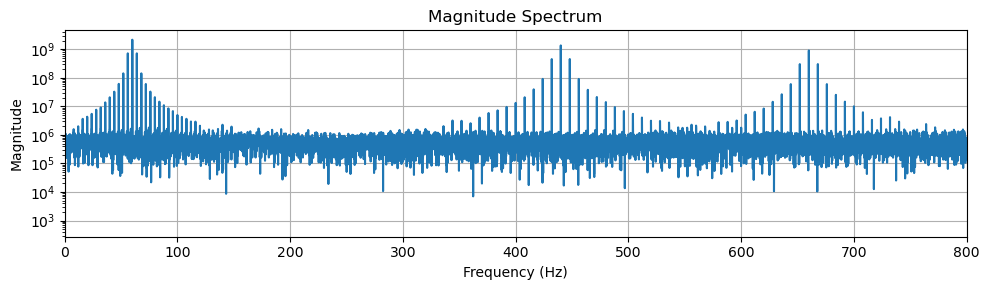

Frequency spectrum plotted. Look for distinct 'blobs' of energy.


In [ ]:
# Analyze: Plot the Frequency Spectrum (FFT)
helper_functions.plot_spectrum(audio_data, sample_rate, n_fft=len(audio_data), xlim=(0, 800), log_scale=True)
print("Frequency spectrum plotted. Look for distinct 'blobs' of energy.")

### Step 1.2: Analyze the Frequency Spectrum

Plot the FFT to visualize the distinct frequency bands. Look for clear "blobs" of energy that represent different instruments.

In [47]:
# Design Filters: Create three bandpass filters using scipy.signal
# Define frequency bands for three instruments (adjust based on spectrum analysis)
# Example: Low (Bass): 50-250 Hz, Mid (Melody): 250-2000 Hz, High (Treble): 2000-5000 Hz

def create_bandpass_filter(sample_rate, lowcut, highcut, order=5):
    """Create a bandpass Butterworth filter."""
    nyquist = sample_rate / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Filter parameters (in Hz)
bands = [
    (1, 200),      # Low frequencies
    (350, 550),    # Mid frequencies
    (550, 750)    # High frequencies
]

filters = []
for lowcut, highcut in bands:
    b, a = create_bandpass_filter(sample_rate, lowcut, highcut, order=4)
    filters.append((b, a))

print(f"Created {len(filters)} bandpass filters")

Created 3 bandpass filters


### Step 1.3: Design Bandpass Filters

Create three Butterworth filters to isolate each frequency band discovered in the spectrum analysis.

Instrument 1 extracted: frequency range 1-200 Hz
Instrument 2 extracted: frequency range 350-550 Hz
Instrument 3 extracted: frequency range 550-750 Hz


TypeError: 'Axes' object is not subscriptable

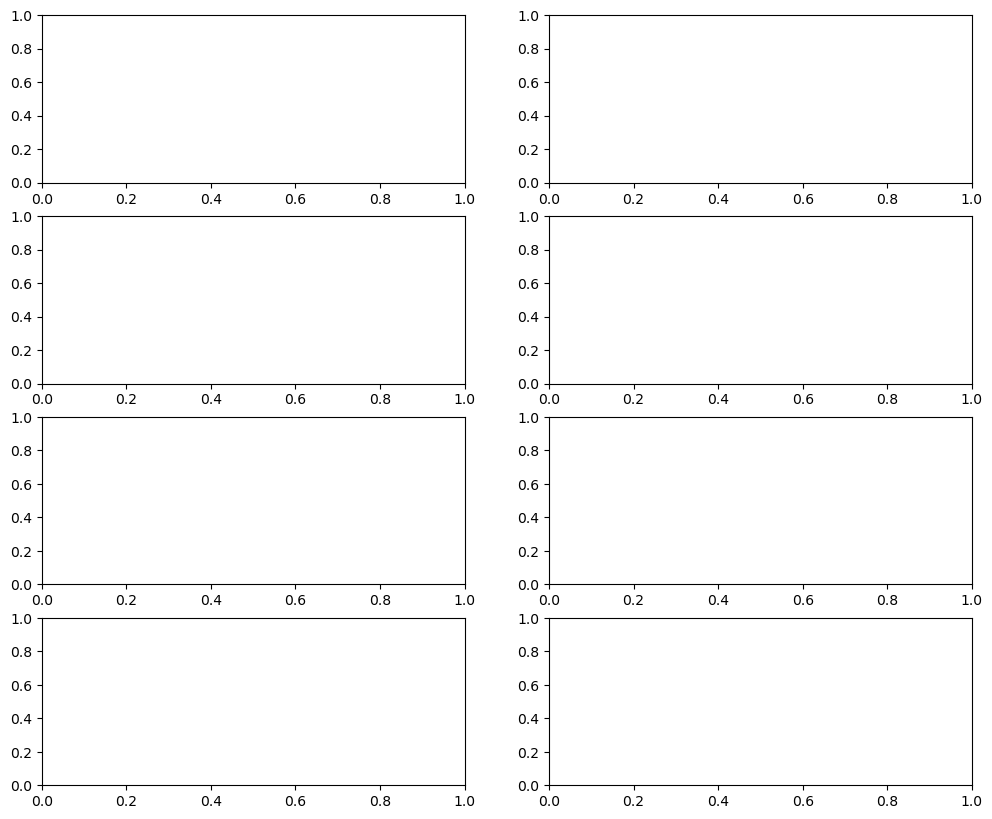

In [ ]:
# Apply: Separate audio tracks using the filters
separated_signals = []
for i, (b, a) in enumerate(filters):
    filtered = filtfilt(b, a, audio_data)
    separated_signals.append(filtered)
    print(f"Instrument {i+1} extracted: frequency range {bands[i][0]}-{bands[i][1]} Hz")

# Verify the separation - plot original and each separated signal
fig, axes = plt.subplots(len(separated_signals) + 1, 2, figsize=(14, 12))

# Plot original signal waveform and spectrum
helper_functions.plot_waveform(audio_data, sample_rate, ax=axes[0, 0], title='Original Mixed Signal')
helper_functions.plot_spectrum(audio_data, sample_rate, n_fft=len(audio_data), ax=axes[0, 1], title='Original Mixed Signal Spectrum', xlim=(0, 800))

# Plot separated signals
for i, signal in enumerate(separated_signals):
    helper_functions.plot_waveform(signal, sample_rate, ax=axes[i+1, 0], title=f'Instrument {i+1} ({bands[i][0]}-{bands[i][1]} Hz)')
    helper_functions.plot_spectrum(signal, sample_rate, n_fft=len(signal), ax=axes[i+1, 1], title=f'Instrument {i+1} Spectrum ({bands[i][0]}-{bands[i][1]} Hz)', xlim=(0, 800))

plt.tight_layout()
plt.show()

print("Signals separated successfully!")

### Step 1.4: Apply Filters and Visualize Results

Apply the filters to separate the audio tracks and visualize the original vs. separated signals.

In [ ]:
# Save the separated audio tracks
output_dir = 'Student_Data_Pack'
os.makedirs(output_dir, exist_ok=True)

for i, signal in enumerate(separated_signals):
    # Normalize to prevent clipping
    signal = np.int16(signal / np.max(np.abs(signal)) * 32767)
    output_file = os.path.join(output_dir, f'instrument_{i+1}.wav')
    wavfile.write(output_file, sample_rate, signal)
    print(f"Saved: {output_file}")

print("\nPhase 1 Complete! All separated audio tracks have been saved.")

### Step 1.5: Save Separated Audio Tracks

Save each separated instrument as an individual audio file for verification and use in later phases.

## Phase 2: The Cocktail Party (ICA)

**Objective:** Separate the "Voice" from the "Background Music" using Blind Source Separation.

1. Construction: Load `Student_Data_Pack/mic_1.wav` and `Student_Data_Pack/mic_2.wav` and assemble them into an appropriate data matrix (rows = channels, columns = samples).
2. Separation: Apply a Blind Source Separation algorithm such as `FastICA` (from `sklearn.decomposition` or `mne.preprocessing`) to recover the independent sources.
3. Recover: Identify which recovered component corresponds to the voice and which corresponds to the music. Save the two output signals (e.g., `source_1.wav` and `source_2.wav`) and listen to them to verify.

Notes:
- If the ICA outputs are scaled or sign-flipped, align their amplitude and sign before saving.
- Visual inspection (waveforms and short-time spectra) can help choose the voice component.

## Phase 2B: The Clean-Up (Post-Processing)

**Objective:** Polish the ICA result by applying a frequency filter to the chosen voice component to remove residual noise and rumble.

1. Select: From the two ICA outputs, identify which signal is the voice (listen and inspect spectrograms).
2. Filter: Design a frequency filter (e.g., high-pass to remove subsonic rumble, low-pass to remove high-frequency noise) using `scipy.signal`.
3. Apply: Filter the chosen voice track and compare before/after spectrograms to verify improvement.
4. Save: Export the cleaned result as `clean_voice.wav` for use in the compression phase.

Notes:
- Use zero-phase filtering (`filtfilt`) to avoid phase distortion when preserving speech intelligibility.
- Keep a copy of the unfiltered ICA output for comparison and reproducibility.

## Phase 3: The Bit-Crusher (Wavelet Compression)

**Objective:** Compress the cleaned voice track to save bandwidth while retaining intelligibility.

1. Decompose: Load `clean_voice.wav` and perform a Discrete Wavelet Transform (DWT) — e.g., level 5 with `'db4'` wavelet — to obtain wavelet coefficients.
2. Threshold: Sort coefficients by magnitude and keep only the top X% (for example, top 20%) — set the rest to zero to achieve compression.
3. Reconstruct: Perform the Inverse DWT using the thresholded coefficients to obtain the compressed audio signal.
4. Analysis: Calculate the compression ratio (size of retained coefficients vs original) and listen to the result to assess quality.

Notes:
- Experiment with the percentage of coefficients retained to find a balance between compression and perceptual quality.
- Consider storing coefficient indices and values efficiently (e.g., run-length or sparse serialization) for real compression tasks.